# Term1 Sprint６ 機械学習スクラッチ　決定木



In [1]:
#基本ライブラリ
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
#scikit-learnライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

#データセット
from sklearn.datasets import load_iris

In [3]:
#今回だけ
import scipy.stats as stats   #scipy.stats.mode用

## 【問題1】ジニ不純度を求める関数


まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成する。ノードtに対するジニ不純度I(t) は以下の数式で求まる。

$$
I(t) = 1- \sum_{i=1}^K P^2(C_i | t) = 1 - \sum_{i=1}^K(\frac{N_{t,i}}{N_{t,all}})^2
$$

- t  : ノードのインデックス
- i : クラスのインデックス
- K : クラスの数
- Ci : i番目のクラス
- P(Ci|t) :　t番目のノードにおける
- Ciの割合Nt,i : t番目のノードのi番目のクラスに属するサンプル数
- Nt,all : t番目のノードのサンプルの総数

まずは簡単な例を作り、手計算と関数の結果を比較する。

例
 - クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
 - クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
 - クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
 - クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [4]:
#手計算
male = np.zeros(40)
female = np.ones(60)
people = np.hstack([male, female])

#サンプル数
ip_nt_all = people.size

#ジニ係数
Ig0 = 1 - ((len(male)/ip_nt_all)**2 + (len(female)/ip_nt_all)**2)

print("サンプル数", ip_nt_all)
print("初期ジニ不純度＝", Ig0)


サンプル数 100
初期ジニ不純度＝ 0.48


In [5]:
#手計算２
np.random.seed(seed=32)

people2 = np.random.permutation(people)   #人工的に閾値

people_left = people2[:60]
people_right = people2[60:]

print("people_left", people_left)
print("people_right", people_right)

#各ノードサンプル数
left_nt_all = people_left.size
right_nt_all = people_right.size

#左ジニ係数
lg1_left = 1 - (
    ((left_nt_all - np.count_nonzero(people_left)) / left_nt_all)**2
                + (np.count_nonzero(people_left) / left_nt_all)**2
)

#右ジニ係数
lg1_right = 1 - (
    ((right_nt_all - np.count_nonzero(people_right)) / right_nt_all)**2
                + (np.count_nonzero(people_right) / right_nt_all)**2)


print("Ig(Dleft)= \n", lg1_left)
print("Ig(Dright)= \n", lg1_right)


people_left [0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
people_right [1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.]
Ig(Dleft)= 
 0.48611111111111105
Ig(Dright)= 
 0.46875


In [6]:
#情報利得
Ig0 - (left_nt_all / ip_nt_all)*lg1_left - (right_nt_all / ip_nt_all)*lg1_right

0.0008333333333333526

### gini_diversity_index()

2クラス分類で考える


In [7]:
def gini_diversity_index(X):
    """
    ジニ不純度を計算する関数
    
    ----
    input: １特徴量のデータ(１次元）
    output：ジニ係数
    """
    #ノードt内のサンプル数
    nt_all = X.size
    
    #クラスリストの取得
    class_list = np.unique(X)
    
    #クラス数の取得
    class_num = class_list.size
    
    #シグマ内加算
    sigma = 0
    
    #クラスiに属するサンプル
    for i in range(class_num):
        sigma += (np.sum(X == class_list[i]) / nt_all)**2
    
    gini = 1-sigma
    
    return gini

In [8]:
#手計算の結果と比較
gini_diversity_index(people)


0.48

## 【問題2】情報利得を求める関数

情報利得：分割精度の指標値　（＝分割前の不純度 - 分割後の不純度）

情報利得を計算する関数を作成する。先ほど作成したジニ不純度 I(t)を計算する関数を呼び出して使う。情報利得IGは以下の数式で求まる。

$$
IG(p) = I(p) - \frac{N_{left,all}}{N_{p,all}}I(left) - \frac{N_{right,all}}{N_{p,all}}I(right)
$$

 - p : 親ノードを示すインデックス

 - left : 左側のノードを示すインデックス

 - right : 右側のノードを示すインデックス
 
（ノードXの不純度）ー（ノードYの割合）＊（ノードY1の不純度）ー（ノードYの割合）＊（ノードY2の不純度）



＜例＞

左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143


### information_gain()

In [9]:
def information_gain(ip, left_gini, right_gini, left_nt_all, right_nt_all):
    """
    情報利得を計算する関数
    
    ----
    <input>
    ip : 親ノードのジニ係数
    left_gini:左ノードのジニ係数
    right_gini:右ノードのジニ係数
    ip_nt_all：親ノードのサンプル数
    left_nt_all：左ノードのサンプル数
    right_nt_all：右ノードのサンプル数
    
    <output>
    情報利得
    """
    ip_nt_all = left_nt_all + right_nt_all

    IG = ip - (left_nt_all / ip_nt_all)*left_gini - (right_nt_all / ip_nt_all)*right_gini

    return IG

In [10]:
#関数の動作確認

information_gain(Ig0, lg1_left, lg1_right, left_nt_all, right_nt_all)

0.0008333333333333526

## 【問題3】深さ1の決定木分類器クラスの作成

深さが1の決定機分類器のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込む。深さ１とは、空間の分割を1回だけ行うことを指す。

**決定木のアルゴリズム**

 ある特徴量の軸に対して、全てのパターンのしきい値を考え、それぞれの情報利得を計算していきます。各点の値をしきい値にする方法が一般的です。（ただし、実際にはしきい値の数は点の数よりひとつ少なくて良いことになります）分割の全候補の中で最も情報利得が大きくなるものをそのノードの分割方法として採用します。

 ジニ不純度が0になるノード、または指定された深さのノードは葉と呼ばれます。葉にはそれぞれ推定時にどのクラスに分類するかを記録しておきます。ジニ不純度が0でない場合は、多数決により分類するクラスを決定します。

### 具体的な理解


In [11]:
#対象となるデータ
print(people2)
print("ジニ係数", gini_diversity_index(people2))

[0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1.]
ジニ係数 0.48


In [12]:
#親ノードの中で情報利得が最も大きい値を探す
ip_gini = gini_diversity_index(people2)
ip_nt_all = people2.size
gain_list = []

for i in range(people2.size-1):
    left = people2[:i+1]
    right = people2[i+1:]
    gain_list.append(
    information_gain(
        ip_gini,
        gini_diversity_index(left),
        gini_diversity_index(right),
        left.size, right.size)
         )

print(max(gain_list))
max(zip(gain_list, range(len(gain_list))))

0.0350724637681159


(0.0350724637681159, 45)

４５番目の敷居が最も大きくなった

### アイリスのデータで考えてみる

In [13]:
iris = load_iris()
nd_Xy  = np.concatenate([iris.data, iris.target.reshape(150,1)], axis=1)

df_0 = pd.DataFrame(nd_Xy, columns=["sepal_length", "sepal_width", "petal_length", "petal_width", "Species"])
df = df_0[df_0["Species"].isin([1, 2])]

df.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,1.0
51,6.4,3.2,4.5,1.5,1.0
52,6.9,3.1,4.9,1.5,1.0
53,5.5,2.3,4.0,1.3,1.0
54,6.5,2.8,4.6,1.5,1.0


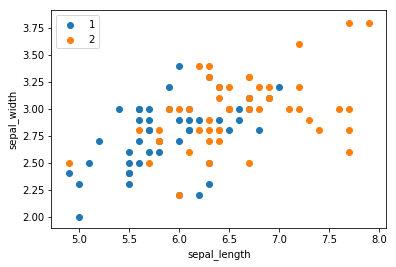

In [14]:
df_1 = df.query("Species == 1").iloc[:,[0,1,4]]   #sepal_lengthとsepal_widthのみ選択
df_2 = df.query("Species == 2").iloc[:,[0,1,4]]

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.scatter(df_1.sepal_length, df_1.sepal_width, label="1")
plt.scatter(df_2.sepal_length, df_2.sepal_width, label="2")
plt.legend()
plt.show()

In [15]:
#閾値のリスト
np.unique(df.sepal_length.values)

array([4.9, 5. , 5.1, 5.2, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2,
       6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.6,
       7.7, 7.9])

In [16]:
#sepal_lengthとターゲットのみのデータ
df_3 = df.iloc[:,[0,4]] 
X = df_3.values
print(X)

[[7.  1. ]
 [6.4 1. ]
 [6.9 1. ]
 [5.5 1. ]
 [6.5 1. ]
 [5.7 1. ]
 [6.3 1. ]
 [4.9 1. ]
 [6.6 1. ]
 [5.2 1. ]
 [5.  1. ]
 [5.9 1. ]
 [6.  1. ]
 [6.1 1. ]
 [5.6 1. ]
 [6.7 1. ]
 [5.6 1. ]
 [5.8 1. ]
 [6.2 1. ]
 [5.6 1. ]
 [5.9 1. ]
 [6.1 1. ]
 [6.3 1. ]
 [6.1 1. ]
 [6.4 1. ]
 [6.6 1. ]
 [6.8 1. ]
 [6.7 1. ]
 [6.  1. ]
 [5.7 1. ]
 [5.5 1. ]
 [5.5 1. ]
 [5.8 1. ]
 [6.  1. ]
 [5.4 1. ]
 [6.  1. ]
 [6.7 1. ]
 [6.3 1. ]
 [5.6 1. ]
 [5.5 1. ]
 [5.5 1. ]
 [6.1 1. ]
 [5.8 1. ]
 [5.  1. ]
 [5.6 1. ]
 [5.7 1. ]
 [5.7 1. ]
 [6.2 1. ]
 [5.1 1. ]
 [5.7 1. ]
 [6.3 2. ]
 [5.8 2. ]
 [7.1 2. ]
 [6.3 2. ]
 [6.5 2. ]
 [7.6 2. ]
 [4.9 2. ]
 [7.3 2. ]
 [6.7 2. ]
 [7.2 2. ]
 [6.5 2. ]
 [6.4 2. ]
 [6.8 2. ]
 [5.7 2. ]
 [5.8 2. ]
 [6.4 2. ]
 [6.5 2. ]
 [7.7 2. ]
 [7.7 2. ]
 [6.  2. ]
 [6.9 2. ]
 [5.6 2. ]
 [7.7 2. ]
 [6.3 2. ]
 [6.7 2. ]
 [7.2 2. ]
 [6.2 2. ]
 [6.1 2. ]
 [6.4 2. ]
 [7.2 2. ]
 [7.4 2. ]
 [7.9 2. ]
 [6.4 2. ]
 [6.3 2. ]
 [6.1 2. ]
 [7.7 2. ]
 [6.3 2. ]
 [6.4 2. ]
 [6.  2. ]
 [6.9 2. ]
 [6.7 2. ]

In [17]:
#ソート
X_sorted = X[np.argsort(X[:, 0])]
print(X_sorted)


[[4.9 2. ]
 [4.9 1. ]
 [5.  1. ]
 [5.  1. ]
 [5.1 1. ]
 [5.2 1. ]
 [5.4 1. ]
 [5.5 1. ]
 [5.5 1. ]
 [5.5 1. ]
 [5.5 1. ]
 [5.5 1. ]
 [5.6 1. ]
 [5.6 1. ]
 [5.6 1. ]
 [5.6 2. ]
 [5.6 1. ]
 [5.6 1. ]
 [5.7 1. ]
 [5.7 1. ]
 [5.7 1. ]
 [5.7 2. ]
 [5.7 1. ]
 [5.7 1. ]
 [5.8 1. ]
 [5.8 2. ]
 [5.8 2. ]
 [5.8 1. ]
 [5.8 2. ]
 [5.8 1. ]
 [5.9 2. ]
 [5.9 1. ]
 [5.9 1. ]
 [6.  2. ]
 [6.  1. ]
 [6.  2. ]
 [6.  1. ]
 [6.  1. ]
 [6.  1. ]
 [6.1 2. ]
 [6.1 2. ]
 [6.1 1. ]
 [6.1 1. ]
 [6.1 1. ]
 [6.1 1. ]
 [6.2 2. ]
 [6.2 1. ]
 [6.2 2. ]
 [6.2 1. ]
 [6.3 1. ]
 [6.3 2. ]
 [6.3 2. ]
 [6.3 2. ]
 [6.3 2. ]
 [6.3 1. ]
 [6.3 2. ]
 [6.3 1. ]
 [6.3 2. ]
 [6.4 2. ]
 [6.4 2. ]
 [6.4 2. ]
 [6.4 2. ]
 [6.4 2. ]
 [6.4 1. ]
 [6.4 1. ]
 [6.5 1. ]
 [6.5 2. ]
 [6.5 2. ]
 [6.5 2. ]
 [6.5 2. ]
 [6.6 1. ]
 [6.6 1. ]
 [6.7 2. ]
 [6.7 2. ]
 [6.7 2. ]
 [6.7 1. ]
 [6.7 2. ]
 [6.7 1. ]
 [6.7 1. ]
 [6.7 2. ]
 [6.8 1. ]
 [6.8 2. ]
 [6.8 2. ]
 [6.9 1. ]
 [6.9 2. ]
 [6.9 2. ]
 [6.9 2. ]
 [7.  1. ]
 [7.1 2. ]
 [7.2 2. ]
 [7.2 2. ]

In [18]:
y_sorted = X_sorted[:,1]
print(y_sorted)

[2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1.
 1. 2. 2. 1. 2. 1. 2. 1. 1. 2. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 2.
 1. 1. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 1. 1.
 2. 2. 2. 1. 2. 1. 1. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


### ScratchDecesionTreeClassifier()

In [39]:
class ScratchDecesionTreeClassifier():
    """
    決定木のスクラッチ実装

    Parameters
    ----------
    verbose : bool　学習過程を出力する場合はTrue

    Attributes
    ----------
    self.threshold_ : 境界の閾値
    """

    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.threshold_ = []
        
        #空間のラベルを保持する
        self.space_label = []
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        決定木を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)　　　学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )　　　　　            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)    検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )　　　            検証用データの正解値
        """
        #特徴量を取得
        self.x_nums = X.shape[1]
        
        #Xとyを結合した行列を得る
        Xy = np.concatenate([X,y], 1)
        
        #親ノードのジニ係数取得
        ip_gini = self.gini_diversity_index(y)
        
        self.best_gain_by_x = []
        
        for i in range(self.x_nums):  #self.x_nums
            gain_list = []                                          #特徴量ごとIGリスト初期化
            Xy_sorted = Xy[np.argsort(Xy[:, i])]        #特徴量iの列でソート
            y_sorted = Xy_sorted[:, -1]                    #ターゲットのみのデータを得る

            for j in range(ip_nt_all-1): 
                left = y_sorted[: j+1]
                right = y_sorted[j+1:]
                gain_list.append(
                self.information_gain(
                    ip_gini,
                    self.gini_diversity_index(left),
                    self.gini_diversity_index(right),
                    left.size,
                    right.size)
                     )    #append end
            
            #特徴量ごとベストIG(p)と閾値追加
            best_igp = list(max(zip(gain_list, range(len(gain_list)))))      #[情報利得, インデックス]
            best_igp.append(Xy_sorted[best_igp[1]][i])                      #[情報利得, インデックス, 閾値]
            self.best_gain_by_x.append(best_igp)                               #bestIGpリストを追加
        
        #最もIGpが高かった特徴量とその閾値を取得
        selected_index = np.argmax(np.array(self.best_gain_by_x)[:, 0], axis=0)
        selected_threshold = self.best_gain_by_x[selected_index][2]
        self.threshold_.append([selected_index, selected_threshold])
        
        #空間ラベル
        #（閾値インデックス番号-1）が実際のラインとなることに注意
        left = Xy[np.argsort(Xy[:, selected_index])][:self.best_gain_by_x[selected_index][1]-1]
        right = Xy[np.argsort(Xy[:, selected_index])][self.best_gain_by_x[selected_index][1]-1:]
        self.space_label = [int(stats.mode(left[:, 2])[0]), int(stats.mode(right[:, 2])[0])]


        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass


    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features) サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)　線形回帰による推定結果
        """
        #基準特徴量選択
        x_num = self.threshold_[0][0]
        selectedX = X[:, x_num]
        
        #推定値へ変換
        f = lambda x: self.space_label[0] if x <= self.threshold_[0][1] else self.space_label[1]
        vf = np.vectorize(f)
        y_hat = vf(selectedX)

        return y_hat

    def gini_diversity_index(self, X):
        """
        ジニ不純度を計算する関数

        ----
        input: １特徴量のデータ(１次元）
        output：ジニ係数
        """
        #ノードt内のサンプル数
        nt_all = X.size

        #クラスリストの取得
        class_list = np.unique(X)

        #クラス数の取得
        class_num = class_list.size

        #シグマ内加算
        sigma = 0

        #クラスiに属するサンプル
        for i in range(class_num):
            sigma += (np.sum(X == class_list[i]) / nt_all)**2

        gini = 1-sigma

        return gini
    
    def information_gain(self, ip, left_gini, right_gini, left_nt_all, right_nt_all):
        """
        情報利得を計算する関数

        ----
        <input>
        ip : 親ノードのジニ係数
        left_gini:左ノードのジニ係数
        right_gini:右ノードのジニ係数
        left_nt_all：左ノードのサンプル数
        right_nt_all：右ノードのサンプル数

        <output>
        情報利得
        """
        ip_nt_all = left_nt_all + right_nt_all

        IG = ip - (left_nt_all / ip_nt_all)*left_gini - (right_nt_all / ip_nt_all)*right_gini

        return IG
    

In [37]:
#テスト
X = df.iloc[:,[0,1,4]].values 

testX = X[:,0:2]
testy = X[:,-1].reshape(-1,1)

DTC = ScratchDecesionTreeClassifier()
DTC.fit(testX, testy)

print("閾値=", DTC.threshold_)

left (48, 3)
right (52, 3)
閾値= [[0, 5.4]]


In [21]:
#最もIGpが高い特徴量の情報を取得
DTC.best_gain_by_x[np.argmax(np.array(DTC.best_gain_by_x)[:, 0], axis=0)]

[0.11519999999999997, 49, 6.3]

## 【問題６】指標値の算出

分かりやすいデータで指標値を算出する。

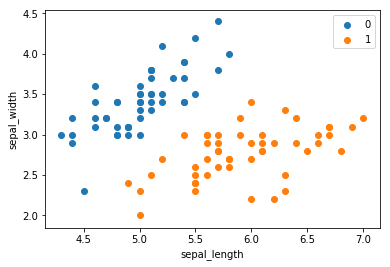

In [22]:
#SetosaとVersicolour
df = df_0[df_0["Species"].isin([0, 1])]

df_1 = df.query("Species == 0").iloc[:,[0,1,4]]   #sepal_lengthとsepal_widthのみ選択
df_2 = df.query("Species == 1").iloc[:,[0,1,4]]

plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.scatter(df_1.sepal_length, df_1.sepal_width, label="0")
plt.scatter(df_2.sepal_length, df_2.sepal_width, label="1")
plt.legend()
plt.show()

In [23]:
#分割
X = df.iloc[:,[0,1]].values    #sepal_lengthとsepal_widthのみ選択
y = df["Species"].values.reshape(-1,1)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.25, random_state=5,) #シードも設定しておく

print("X_train", np.shape(X_train))
print("X_test", np.shape(X_test))
print("y_train", np.shape(y_train))
print("y_test", np.shape(y_test))

X_train (75, 2)
X_test (25, 2)
y_train (75, 1)
y_test (25, 1)


In [24]:
#学習
DTC2 = ScratchDecesionTreeClassifier()
DTC2.fit(X_train, y_train)

print("特徴量, 閾値＝", DTC2.threshold_)
print("各特徴量スコア=", DTC2.best_gain_by_x)
print("空間ラベル", DTC2.space_label)

特徴量, 閾値＝ [[1, 3.0]]
各特徴量スコア= [[0.2852045617464973, 30, 5.4], [0.28790617986407463, 37, 3.0]]
空間ラベル [1, 0]


In [25]:
#予測
y_pred = DTC2.predict(X_test)
y_pred

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0])

In [26]:
#スコア
original_list = [metrics.accuracy_score(y_test, y_pred),
           metrics.precision_score(y_test, y_pred), 
           metrics.recall_score(y_test, y_pred),
           metrics.f1_score(y_test, y_pred) ]

#print("オフィシャル", official_list)
print("スクラッチのスコア　\n", original_list)

スクラッチのスコア　
 [0.88, 0.875, 0.7777777777777778, 0.823529411764706]


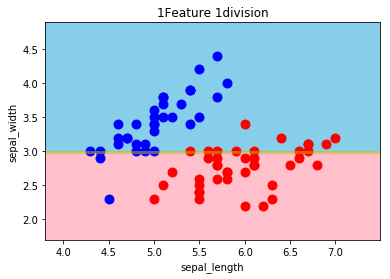

In [29]:
#Trainデータ可視化
decision_region_1f(X_train, y_train, DTC2, xlabel="sepal_length", ylabel="sepal_width", title="1Feature 1division")

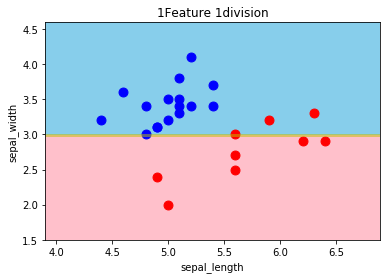

In [30]:
#Testデータ可視化
decision_region_1f(X_test, y_test, DTC2, xlabel="sepal_length", ylabel="sepal_width", title="1Feature 1division")

## 【問題７】決定領域の可視化

In [32]:
#可視化関数

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region_1f(X, y, model, step=0.01, title='decision region',
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    selected = model.threshold_[0][0]
    target1 = model.space_label[0]
    target2 = model.space_label[1]
    Xy = np.concatenate([X,y],1)
    df = pd.DataFrame(Xy, columns=["f1","f2","target"])
    df_1 = df[df['target'] == target1]
    df_2 = df[df['target'] == target2]

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(
                                    np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), #特徴量１の最小値〜最大値生成
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step) #特徴量2の最小値〜最大値生成
    )
    mesh_list = [mesh_f0, mesh_f1]
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]  #メッシュの格子データを一次元化して横に結合
    #print(mesh)
    #print(mesh.shape)
    f = lambda x: 1 if x >= model.threshold_[0][1] else 0
    vf = np.vectorize(f)
    z = vf(np.ravel(mesh_list[selected]))
    
    y_pred = z.reshape(mesh_f0.shape) #全ての格子点の予測値を取得

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color)) #面
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5) #線
    
    plt.scatter(df_1["f1"], df_1["f2"], s=80, color=scatter_color[0], label=target_names[0], marker='o')
    plt.scatter(df_2["f1"], df_2["f2"], s=80, color=scatter_color[1], label=target_names[1], marker='o')
    plt.show()

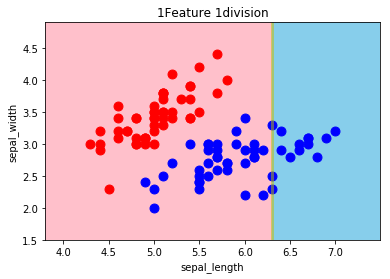

In [33]:
#特徴量１つ、分割1回の場合

vision = df.iloc[:,[0,1]].values
decision_region_1f(vision, testy, DTC, xlabel="sepal_length", ylabel="sepal_width", title="1Feature 1division")

## 【問題4】深さ２の決定木分類器クラスの作成

2020.1.20 現在　作りかけ

In [49]:
class Branch():
    """
    ブランチのクラス
    """
    def __init__(self):
        self.threshold_ = []
        
        #空間のラベルを保持する
        self.space_label = []
        pass
    
    def fit(self, Xy, label=None):
        
        X = Xy[:, 0:-2]
        y = Xy[:, -1]
        
        #特徴量を取得
        self.x_nums = X.shape[1]
                
        #親ノードのジニ係数取得
        ip_gini = self.gini_diversity_index(y)
        
        self.best_gain_by_x = []
        
        for i in range(self.x_nums):  #self.x_nums
            gain_list = []                                          #特徴量ごとIGリスト初期化
            Xy_sorted = Xy[np.argsort(Xy[:, i])]        #特徴量iの列でソート
            y_sorted = Xy_sorted[:, -1]                    #ターゲットのみのデータを得る

            for j in range(ip_nt_all-1): 
                left = y_sorted[: j+1]
                right = y_sorted[j+1:]
                gain_list.append(
                self.information_gain(
                    ip_gini,
                    self.gini_diversity_index(left),
                    self.gini_diversity_index(right),
                    left.size,
                    right.size)
                     )    #append end
            
            #特徴量ごとベストIG(p)と閾値追加
            best_igp = list(max(zip(gain_list, range(len(gain_list)))))      #[情報利得, インデックス]
            best_igp.append(Xy_sorted[best_igp[1]][i])                      #[情報利得, インデックス, 閾値]
            self.best_gain_by_x.append(best_igp)                               #bestIGpリストを追加
        
        #最もIGpが高かった特徴量とその閾値を取得
        selected_index = np.argmax(np.array(self.best_gain_by_x)[:, 0], axis=0)
        selected_threshold = self.best_gain_by_x[selected_index][2]
        self.threshold_.append([selected_index, selected_threshold])
        
        #空間ラベル
        #（閾値インデックス番号-1）が実際のラインとなることに注意
        left = Xy[np.argsort(Xy[:, selected_index])][:self.best_gain_by_x[selected_index][1]-1]
        right = Xy[np.argsort(Xy[:, selected_index])][self.best_gain_by_x[selected_index][1]-1:]
        print(" ")
        print("left", left.shape)
        print("right", right.shape)
        self.space_label = [int(stats.mode(left[:, 2])[0]), int(stats.mode(right[:, 2])[0])]
        
        return left, self.space_label[0], right, self.space_label[1]
        
    def gini_diversity_index(self, X):
        """
        ジニ不純度を計算する関数

        ----
        input: １特徴量のデータ(１次元）
        output：ジニ係数
        """
        nt_all = X.size                         #ノードt内のサンプル数
        class_list = np.unique(X)         #クラスリストの取得
        sigma = 0                              #シグマ内加算

        #クラスiに属するサンプル
        for i in range(class_list.size):
            sigma += (np.sum(X == class_list[i]) / nt_all)**2

        return 1-sigma
    
    def information_gain(self, ip, left_gini, right_gini, left_nt_all, right_nt_all):
        """
        情報利得を計算する関数

        ----
        <input>
        ip : 親ノードのジニ係数
        left_gini:左ノードのジニ係数
        right_gini:右ノードのジニ係数
        left_nt_all：左ノードのサンプル数
        right_nt_all：右ノードのサンプル数

        <output>
        情報利得
        """
        ip_nt_all = left_nt_all + right_nt_all

        IG = ip - (left_nt_all / ip_nt_all)*left_gini - (right_nt_all / ip_nt_all)*right_gini

        return IG
    

In [54]:
class ScratchDecesionTreeClassifier_2D():
    """
    深さ２の決定木のスクラッチ実装

    Parameters
    ----------
    verbose : bool　学習過程を出力する場合はTrue

    Attributes
    ----------
    self.threshold_ : 境界の閾値
    """

    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.threshold_ = []
        
        #空間のラベルを保持する
        self.space_label = []
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        決定木を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)　　　学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )　　　　　            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)    検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )　　　            検証用データの正解値
        """
        #インスタンス化
        self.D1 = Branch()
        self.D2_L = Branch()
        self.D2_R = Branch()
        
        #Xとyを結合した行列を得る
        Xy = np.concatenate([X,y], 1)

        #Depth1
        d2_left, left_label, d2_right, right_label = self.D1.fit(Xy)
        
        #Depth2
        self.D2_L.fit(d2_left, label = left_label)
        self.D2_R.fit(d2_right, label = right_label)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass


    def predict(self, X):
        """
        線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features) サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)　線形回帰による推定結果
        """
        #基準特徴量選択
        x_num = self.threshold_[0][0]
        selectedX = X[:, x_num]
        
        #推定値へ変換
        f = lambda x: self.space_label[0] if x <= self.threshold_[0][1] else self.space_label[1]
        vf = np.vectorize(f)
        y_hat = vf(selectedX)

        return y_hat
    

In [55]:
#テスト
X = df.iloc[:,[0,1,4]].values 

testX = X[:,0:2]
testy = X[:,-1].reshape(-1,1)

DTC2D = ScratchDecesionTreeClassifier_2D()
DTC2D.fit(X_train, y_train)

 
left (29, 3)
right (46, 3)
 
left (16, 3)
right (13, 3)
 
left (3, 3)
right (43, 3)


In [59]:
print(DTC2D.D1.threshold_)
print(DTC2D.D2_L.threshold_)
print(DTC2D.D2_R.threshold_)

[[0, 5.4]]
[[0, 5.0]]
[[0, 5.5]]


In [ ]:
decision_region_1f(X_train, y_train, DTC2D, xlabel="sepal_length", ylabel="sepal_width", title="1Feature 1division")